The Earth Engine API lacks functions for analyzing and visualizing machine learning models. There are several implementations available from the community to fill this gap - including us. As an alternative, we can export our training samples from GEE and use widely-used machine learning packages like Scikit-Learn to carry out this analysis. This notebook demonstrates the process of Exporting the training samples as a CSV file and using it with Scikit-Learn for the following analysis


*   Analyzing Feature Importance using GINI Importance
*   Visualizing Random Forest Trees



#### Initialization

First of all, you need to run the following cells to initialize the API and authorize your account. You must have a Google Cloud Project associated with your GEE account. Replace the `cloud_project` with your own project from [Google Cloud Console](https://console.cloud.google.com/).

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
cloud_project = 'spatialthoughts'

try:
    ee.Initialize(project=cloud_project)
except:
    ee.Authenticate()
    ee.Initialize(project=cloud_project)

#### Part 1: Export Training Samples from GEE

In [ ]:
# Load training samples
gcps = ee.FeatureCollection('projects/spatialthoughts/assets/e2e/exported_gcps')

# Load the region boundary of a basin
boundary = ee.FeatureCollection('projects/spatialthoughts/assets/e2e/basin_boundary')
geometry = boundary.geometry()

year = 2019
startDate = ee.Date.fromYMD(year, 1, 1)
endDate = startDate.advance(1, 'year')

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

filtered = s2 \
.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
.filter(ee.Filter.date(startDate, endDate)) \
.filter(ee.Filter.bounds(geometry))

# Load the Cloud Score+ collection
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
csPlusBands = csPlus.first().bandNames()

# We need to add Cloud Score + bands to each Sentinel-2
# image in the collection
# This is done using the linkCollection() function
filteredS2WithCs = filtered.linkCollection(csPlus, csPlusBands)

# Function to mask pixels with low CS+ QA scores.
def maskLowQA(image):
    qaBand = 'cs'
    clearThreshold = 0.5
    mask = image.select(qaBand).gte(clearThreshold)
    return image.updateMask(mask)

filteredMasked = filteredS2WithCs \
  .map(maskLowQA) \
  .select('B.*')

composite = filteredMasked.median()

# Add Spectral Indices
def addIndices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename(['ndvi'])
    ndbi = image.normalizedDifference(['B11', 'B8']).rename(['ndbi'])
    mndwi = image.normalizedDifference(['B3', 'B11']).rename(['mndwi'])
    bsi = image.expression(
    '(( X + Y ) - (A + B)) /(( X + Y ) + (A + B)) ', {
            'X': image.select('B11'),
            'Y': image.select('B4'),
            'A': image.select('B8'),
            'B': image.select('B2'),
        }).rename('bsi')
    return image.addBands(ndvi).addBands(ndbi).addBands(mndwi).addBands(bsi)

composite = addIndices(composite)

# Add Slope and Elevation

# Use ALOS World 3D
alos = ee.ImageCollection('JAXA/ALOS/AW3D30/V4_1')

# This comes as a collection of images
# We mosaic it to create a single image

# Need to set the projection correctly on the mosaic
# for the slope computation
proj = alos.first().projection()

elevation = alos.select('DSM').mosaic() \
  .setDefaultProjection(proj) \
  .rename('elev')

slope = ee.Terrain.slope(elevation) \
  .rename('slope')

composite = composite.addBands(elevation).addBands(slope)

print('Composite Bands', composite.bandNames().getInfo())

# Train the model with new features

# Add a random column and split the GCPs into training and validation set
gcps = gcps.randomColumn()

# This being a simpler classification, we take 60% points
# for validation. Normal recommended ratio is
# 70% training, 30% validation
trainingGcp = gcps.filter(ee.Filter.lt('random', 0.6))
validationGcp = gcps.filter(ee.Filter.gte('random', 0.6))

# Overlay the samples on the image to get training data.
training = composite.sampleRegions(**{
  'collection': trainingGcp,
  'properties': ['landcover'],
  'scale': 10,
  'tileScale': 16,
})

print('Training Feature', training.first().getInfo())

Export the training features as a CSV file. We use `Export.table.toCloudStorage()` for ease of sharing.

If you want to Export the samples to your Drive, run the follow code to mount your drive in Colab.

```
# Mount Google Drive
drive.mount('/content/drive')

# Adjust the path to where you saved your CSV in Drive
export_folder = '/content/drive/MyDrive/earthengine'
```



In [ ]:
bucket = 'spatialthoughts-public-data'
folder = 'e2e'
export_folder = f'gs://{bucket}/{folder}'
export_name = 'training_samples'
file_name_prefix = f'{folder}/{export_name}'

# Create an export task using ee.batch.Export.table.toCloudStorage()
task = ee.batch.Export.table.toCloudStorage(**{
    'collection': training,
    'description': 'Training_Samples_Export',
    'bucket': 'spatialthoughts-public-data',
    'fileNamePrefix': 'e2e/training_samples',
    'fileFormat': 'CSV',
})

# Start the task
#task.start()

print('Started Training Samples Export Task')

#### Part 2: Analysis with Scikit-Learn

We read the exported training samples.

In [ ]:
gcs_url = 'https://storage.googleapis.com'
file_path = f'{gcs_url}/{bucket}/{folder}/{export_name}.csv'
df = pd.read_csv(file_path)
df

Train a Random Forest Model.

In [ ]:
feature_cols = [
    'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
    'B8A','B9', 'B11', 'B12','ndvi', 'ndbi', 'mndwi',
    'bsi', 'elev', 'slope'
]
target_col = 'landcover'

x = df[feature_cols]
y = df[target_col]

rf_classifier = RandomForestClassifier(
    n_estimators=50,  # Number of trees in the forest
    max_depth=5,      # Maximum depth of the trees
    random_state=42   # Seed for reproducibility
)

# Train the classifier on the training data
rf_classifier.fit(x, y)

Visualize GINI Importance

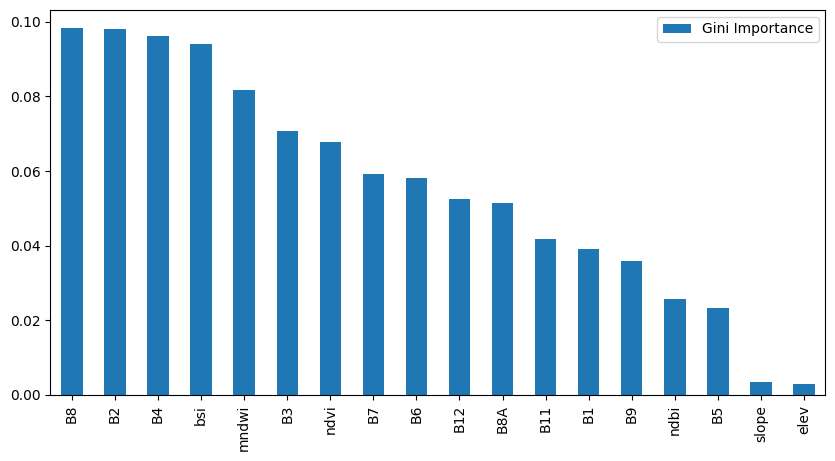

In [59]:
# Built-in feature importance (Gini Importance)
importances = rf_classifier.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Gini Importance': importances
  }).sort_values('Gini Importance', ascending=False)

# Plot the results
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,5)
feature_importance.plot(kind='bar', ax=ax)
ax.set_xticklabels(feature_importance['Feature'], rotation=90)
plt.show()

We can also visualize the individual decision trees created by the Random Forest algorithm.

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Export one of the trees
tree_index = 0
output_file_path = f'decision_tree_{tree_index}'
tree_to_visualize = rf_classifier.estimators_[tree_index] # Visualize the first tree

dot_data = export_graphviz(
    tree_to_visualize,
    out_file=None,
    feature_names=feature_cols,
    class_names=[str(cls) for cls in rf_classifier.classes_], # Convert class names to strings
    rounded=True,
    special_characters=True,
    impurity=False
)

# Visualize the tree
graph = graphviz.Source(dot_data)
graph.render(output_file_path, format='png', cleanup=True)

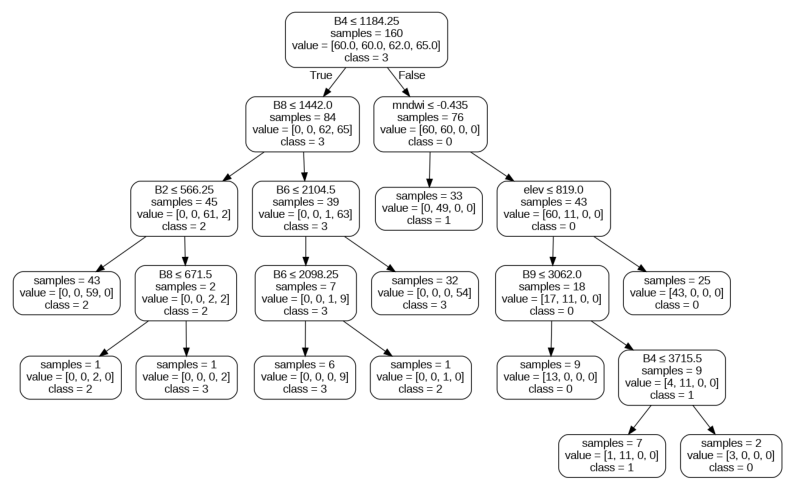

In [60]:
import matplotlib.pyplot as plt
import os

# Plot the results
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
img = mpimg.imread(f'{output_file_path}.png')
ax.imshow(img)
plt.axis('off')
plt.show()
